In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.metrics import f1_score
from sklearn.linear_model import Perceptron as pc
from sklearn.neural_network import MLPClassifier as mlp


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Data 

In [2]:
drug_data = pd.read_csv('drug200.csv')

drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


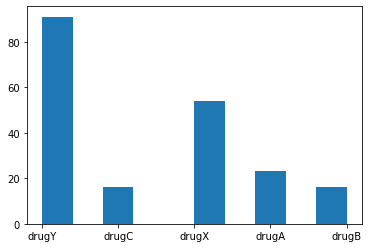

In [3]:
# Need to add axis labels and title

x = plt.hist(drug_data.Drug)
plt.savefig('Drug_Distribution_Data.pdf')

In [4]:
N_to_K = drug_data.Na_to_K
Age = drug_data.Age
Sex_nf = pd.get_dummies(drug_data.Sex)
BP_nf = pd.Categorical(drug_data.BP, ordered = True, categories = ['LOW', 'NORMAL', 'HIGH'])
Chol_nf = pd.Categorical(drug_data.Cholesterol, ordered = True, categories = ['NORMAL', 'HIGH'])
BP_nf = pd.DataFrame({'BP': BP_nf.codes})
Chol_nf = pd.DataFrame({'Cholesterol' :Chol_nf.codes})

In [5]:
drug_features = [Age, Sex_nf, BP_nf, Chol_nf, N_to_K]
drug_features = pd.concat(drug_features, axis=1, join = 'inner')
drug_target = drug_data.Drug


In [6]:
x_train, x_test, y_train, y_test = sk.train_test_split(drug_features, drug_target)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Metrics

In [7]:
def getMetrics(drug_classes, index, pred, targets):
    class_recall = recall_score(targets, pred, average= None)
    class_precision = precision_score(targets, pred, average= None, zero_division = 0)
    class_f1 = f1_score(targets, pred, average= None)
    model_accuracy = accuracy_score(targets, pred)
    model_f1_macro = f1_score(targets, pred, average= 'macro')
    model_f1_weighted = f1_score(targets, pred, average= 'weighted')

    class_recall_labelled = {}
    class_precision_labelled = {}
    class_f1_labelled = {}
    
    for i in range(len(drug_classes)):
        class_recall_labelled[drug_classes[i]] = class_recall[i]
        class_precision_labelled[drug_classes[i]] = class_precision[i]
        class_f1_labelled[drug_classes[i]] = class_f1[i]
    
    metrics = {'Accuracy': model_accuracy, 'F1 Macro': model_f1_macro, 'F1 Weighted' : model_f1_weighted, \
               'Class Recall': class_recall_labelled, 'Class Precision' : class_precision_labelled, 'Class F1': class_f1_labelled}
    
    return metrics
    

In [8]:
def print_model_file(model, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n(A)\n\n')
        if type(model) != 'GridSearchCV':
            metrics_file.write("********************************************************************************\n" +
            type(model).__name__ + '\n'
            'Parameters: '+ ' ' + str(model._get_param_names()) + '\n'+
            "********************************************************************************\n")

        else:
            metrics_file.write("********************************************************************************\n" +
            model.get_params()['estimator'] + ' ' +type(model).___name__ + '\n'   +              
            'Parameters: '+ ' ' + str(model.best_params_) + '\n'+
            "********************************************************************************\n")
            
        
def print_metrics_file(metrics, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n\n(C)')
        
        for key, value in metrics.items():            
            if type(metrics[key]) == dict:
                metrics_file.write('\n\n' +key)
                for key2, value2 in metrics[key].items():
                    metrics_file.write('\n   ' +str(key2) + ' ' + str(value2))
        
        metrics_file.write('\n\n(D)')
        for key, value in metrics.items():
                if type(metrics[key]) != dict :
                    metrics_file.write('\n\n' +str(key) + ' ' + str(value))
        metrics_file.write('\n\n')
    
    
def print_matrix_file(model, pred, targets, file):
    drug_classes = model.classes_
    cm = confusion_matrix(targets, pred, labels = drug_classes)
    drug_classes = [x[-1] for x in drug_classes]
    
    with open(file, 'a') as metrics_file:
        elements = '{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('\n(B)\n\n')
        for i in range(len(drug_classes)):
            elements = elements.format(cm[i, 0], cm[i, 1], cm[i, 2], cm[i, 3], cm[i, 4])
            print(elements)
            metrics_file.write(drug_classes[i] + '  ' + elements+ '\n')
            elements ='{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('   '+'   '.join(drug_classes))



# Guassian Naive-Bayes

In [9]:
cl_gnb = gnb().fit(x_train, y_train)

In [10]:
type(cl_gnb.classes_)

numpy.ndarray

In [11]:
predictions_cl_gnb = cl_gnb.predict(x_train).reshape(150, 1)
index = x_train.index.values.reshape(150, 1)
targets_cl_gnb = y_train.reshape(150, 1)


drug_classes=cl_gnb.classes_
m = getMetrics(drug_classes, index, predictions_cl_gnb, targets_cl_gnb)
print_model_file(cl_gnb, 'test.txt')
print_matrix_file(cl_gnb, predictions_cl_gnb, targets_cl_gnb, 'test.txt')
print_metrics_file(m, 'test.txt')

18  0   0   0   0  
0   14  0   0   0  
0   0   11  0   0  
0   0   0   37  1  
5   4   9   0   51 


# Decision Tree

In [12]:
cl_dtc = dtc().fit(x_train, y_train)

In [29]:
predictions_cl_dtc = cl_dtc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_dtc = y_test.reshape(50, 1)

drug_classes=cl_dtc.classes_
m = getMetrics(drug_classes, index, predictions_cl_dtc, targets_cl_dtc)
print_model_file(cl_dtc, 'test.txt')
print_matrix_file(cl_dtc, predictions_cl_dtc, targets_cl_dtc, 'test.txt')
print_metrics_file(m, 'test.txt')

Class Recall : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 0.9375, 'drugY': 1.0}
Class Precision : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 1.0, 'drugY': 0.9565217391304348}
Class F1 : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 0.967741935483871, 'drugY': 0.9777777777777777}
Model Accuracy :  0.98
Model F1 Macro :  0.9891039426523298
Model F1 Weighted :  0.9798996415770609
5   0   0   0   0  
0   2   0   0   0  
0   0   5   0   0  
0   0   0   15  1  
0   0   0   0   22 


# Top- DT

In [15]:
cl_topdtc = dtc()
cl_topdtc.get_params()
params = {'criterion': ['entropy', 'gini'], 'max_depth' : [1, 2, 3, 4, 5, 3, 7 ], 'min_samples_split': [2, 3, 4]}
sc = sk.GridSearchCV(cl_topdtc, params, scoring='f1_weighted')

In [16]:
sc.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 3, 7],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1_weighted')

In [17]:
sc.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [18]:
predictions_cl_topdtc = sc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_topdtc = y_test.reshape(50, 1)

drug_classes=sc.classes_
m = getMetrics(drug_classes, index, predictions_cl_topdtc, targets_cl_topdtc)
print_model_file(sc, 'test.txt')
print_matrix_file(sc, predictions_cl_topdtc, targets_cl_topdtc, 'test.txt')
print_metrics_file(m, 'test.txt')

Class Recall : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 0.9375, 'drugY': 1.0}
Class Precision : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 1.0, 'drugY': 0.9565217391304348}
Class F1 : 
 {'drugA': 1.0, 'drugB': 1.0, 'drugC': 1.0, 'drugX': 0.967741935483871, 'drugY': 0.9777777777777777}
Model Accuracy :  0.98
Model F1 Macro :  0.9891039426523298
Model F1 Weighted :  0.9798996415770609
5   0   0   0   0  
0   2   0   0   0  
0   0   5   0   0  
0   0   0   15  1  
0   0   0   0   22 


# Perceptron

In [19]:
cl_pc = pc()

pc_x_train = x_train.to_numpy()
pc_x_test = x_test.to_numpy()

In [20]:
cl_pc.fit(pc_x_train, y_train)

Perceptron()

In [21]:
predictions_cl_pc = cl_pc.predict(pc_x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_pc = y_test.reshape(50, 1)

drug_classes=cl_pc.classes_
m = getMetrics(drug_classes, index, predictions_cl_pc, targets_cl_pc)
print_model_file(cl_pc, 'test.txt')
print_matrix_file(cl_dtc, predictions_cl_pc, targets_cl_pc, 'test.txt')
print_metrics_file(m, 'test.txt')

Class Recall : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 1.0}
Class Precision : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 0.44}
Class F1 : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 0.6111111111111112}
Model Accuracy :  0.44
Model F1 Macro :  0.12222222222222223
Model F1 Weighted :  0.26888888888888896
0   0   0   0   5  
0   0   0   0   2  
0   0   0   0   5  
0   0   0   0   16 
0   0   0   0   22 


# MLP

In [22]:
cl_mlp = mlp(hidden_layer_sizes = (1, 100), activation = 'logistic', solver = 'sgd')

In [23]:
cl_mlp.fit(x_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(1, 100), solver='sgd')

In [24]:
predictions_cl_mlp = cl_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_mlp = y_test.reshape(50, 1)

drug_classes=cl_mlp.classes_
m = getMetrics(drug_classes, index, predictions_cl_mlp, targets_cl_mlp)
print_model_file(cl_mlp, 'test.txt')
print_matrix_file(cl_mlp, predictions_cl_mlp, targets_cl_mlp, 'test.txt')
print_metrics_file(m, 'test.txt')

Class Recall : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 1.0}
Class Precision : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 0.44}
Class F1 : 
 {'drugA': 0.0, 'drugB': 0.0, 'drugC': 0.0, 'drugX': 0.0, 'drugY': 0.6111111111111112}
Model Accuracy :  0.44
Model F1 Macro :  0.12222222222222223
Model F1 Weighted :  0.26888888888888896
0   0   0   0   5  
0   0   0   0   2  
0   0   0   0   5  
0   0   0   0   16 
0   0   0   0   22 


# Top MLP

In [25]:
cl_topmlp = mlp()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [26]:
params = {'activation': ['logistic', 'tanh', 'relu', 'identity'], 'hidden_layer_sizes': [(20, 50), (10, 10, 10)]}

sc_mlp = sk.GridSearchCV(cl_topmlp, params)

sc_mlp.fit(x_train, y_train)


C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(20, 50), (10, 10, 10)]})

In [27]:
predictions_cl_topmlp = sc_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_topmlp = y_test.reshape(50, 1)

drug_classes=sc_mlp.classes_
m = getMetrics(drug_classes, index, predictions_cl_topmlp, targets_cl_topmlp)
print_model_file(sc_mlp, 'test.txt')
print_matrix_file(sc_mlp, predictions_cl_topmlp, targets_cl_topmlp, 'test.txt')
print_metrics_file(m, 'test.txt')

Class Recall : 
 {'drugA': 0.6, 'drugB': 1.0, 'drugC': 0.0, 'drugX': 0.625, 'drugY': 1.0}
Class Precision : 
 {'drugA': 0.5, 'drugB': 0.6666666666666666, 'drugC': 0.0, 'drugX': 0.7692307692307693, 'drugY': 0.7857142857142857}
Class F1 : 
 {'drugA': 0.5454545454545454, 'drugB': 0.8, 'drugC': 0.0, 'drugX': 0.6896551724137931, 'drugY': 0.88}
Model Accuracy :  0.74
Model F1 Macro :  0.5830219435736677
Model F1 Weighted :  0.6944351097178684
3   1   0   1   0  
0   2   0   0   0  
1   0   0   2   2  
2   0   0   10  4  
0   0   0   0   22 


dict